# LSTM FROM SCRATCH: COMPLETE IMPLEMENTATION

This notebook implements a Long Short-Term Memory (LSTM) network from scratch in PyTorch,
training it on the Tiny Shakespeare dataset (tiny.txt) using word-level tokenization.

We'll visualize each gate component and understand how LSTMs solve the vanishing gradient problem.

## Part 1: Understanding LSTM Architecture

An LSTM cell has three gates and two states:

**Gates:**
- **Forget Gate (f)**: Decides what information to discard from cell state
- **Input Gate (i)**: Decides what new information to store in cell state  
- **Output Gate (o)**: Decides what to output based on cell state

**States:**
- **Cell State (C)**: Long-term memory, flows through time with minor linear interactions
- **Hidden State (h)**: Short-term memory, output at each timestep

**Equations:**
```
f_t = σ(W_f @ x_t + U_f @ h_{t-1} + b_f)     # Forget gate
i_t = σ(W_i @ x_t + U_i @ h_{t-1} + b_i)     # Input gate
g_t = tanh(W_g @ x_t + U_g @ h_{t-1} + b_g)  # Candidate cell state
o_t = σ(W_o @ x_t + U_o @ h_{t-1} + b_o)     # Output gate

C_t = f_t ⊙ C_{t-1} + i_t ⊙ g_t              # Update cell state
h_t = o_t ⊙ tanh(C_t)                         # Update hidden state
```

where σ is sigmoid and ⊙ is element-wise multiplication

In [17]:
# Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyBboxPatch
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

### Understanding Basic Operations

Before diving into LSTMs, let's understand the key mathematical operations we'll use:
- **Matrix multiplication (@)**: Transforms data from one space to another
- **Element-wise multiplication (*)**: Applies gating/filtering operations
- **Sigmoid (σ)**: Squashes values to range [0, 1], used for gates
- **Tanh**: Squashes values to range [-1, 1], used for state values

EXAMPLE 1: Matrix Multiplication (@)
Input vector: tensor([1., 2., 3.])
Input shape: torch.Size([3])

Weight matrix shape: torch.Size([4, 3])
Weight matrix:
tensor([[0.5000, 0.2000, 0.1000],
        [0.3000, 0.4000, 0.2000],
        [0.1000, 0.1000, 0.8000],
        [0.6000, 0.3000, 0.1000]])

Output after transformation: tensor([1.2000, 1.7000, 2.7000, 1.5000])
Output shape: torch.Size([4])

How each output element is computed:
  Output[0] = 0.5*1.0 + 0.2*2.0 + 0.1*3.0 = 1.2
  Output[1] = 0.3*1.0 + 0.4*2.0 + 0.2*3.0 = 1.7
  Output[2] = 0.1*1.0 + 0.1*2.0 + 0.8*3.0 = 2.7
  Output[3] = 0.6*1.0 + 0.3*2.0 + 0.1*3.0 = 1.5


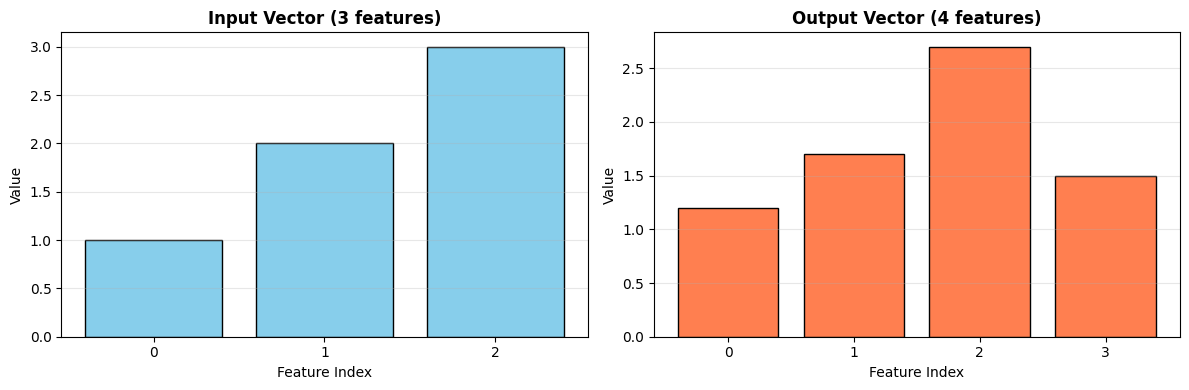


Key Insight: Matrix multiplication lets us transform data from one
             dimensional space to another through learned weights!


In [18]:
# Example 1: Matrix Multiplication (@)
# The @ operator performs matrix multiplication
# This is used to transform input data through learned weight matrices

print("=" * 70)
print("EXAMPLE 1: Matrix Multiplication (@)")
print("=" * 70)

# Create a simple input vector (like a word embedding)
input_vector = torch.tensor([1.0, 2.0, 3.0])  # Shape: (3,) - 3 features
print(f"Input vector: {input_vector}")
print(f"Input shape: {input_vector.shape}\n")

# Create a weight matrix (transforms 3 features to 4 features)
weight_matrix = torch.tensor([
    [0.5, 0.2, 0.1],  # Row 1: weights for output feature 1
    [0.3, 0.4, 0.2],  # Row 2: weights for output feature 2
    [0.1, 0.1, 0.8],  # Row 3: weights for output feature 3
    [0.6, 0.3, 0.1]   # Row 4: weights for output feature 4
])  # Shape: (4, 3)
print(f"Weight matrix shape: {weight_matrix.shape}")
print(f"Weight matrix:\n{weight_matrix}\n")

# Matrix multiplication: transforms input from 3D to 4D space
output = weight_matrix @ input_vector  # Result shape: (4,)
print(f"Output after transformation: {output}")
print(f"Output shape: {output.shape}")

# How it works: each output element is a weighted sum
print("\nHow each output element is computed:")
print(f"  Output[0] = {weight_matrix[0,0]:.1f}*{input_vector[0]:.1f} + {weight_matrix[0,1]:.1f}*{input_vector[1]:.1f} + {weight_matrix[0,2]:.1f}*{input_vector[2]:.1f} = {output[0]:.1f}")
print(f"  Output[1] = {weight_matrix[1,0]:.1f}*{input_vector[0]:.1f} + {weight_matrix[1,1]:.1f}*{input_vector[1]:.1f} + {weight_matrix[1,2]:.1f}*{input_vector[2]:.1f} = {output[1]:.1f}")
print(f"  Output[2] = {weight_matrix[2,0]:.1f}*{input_vector[0]:.1f} + {weight_matrix[2,1]:.1f}*{input_vector[1]:.1f} + {weight_matrix[2,2]:.1f}*{input_vector[2]:.1f} = {output[2]:.1f}")
print(f"  Output[3] = {weight_matrix[3,0]:.1f}*{input_vector[0]:.1f} + {weight_matrix[3,1]:.1f}*{input_vector[1]:.1f} + {weight_matrix[3,2]:.1f}*{input_vector[2]:.1f} = {output[3]:.1f}")

# Visualize the transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(3), input_vector.numpy(), color='skyblue', edgecolor='black')
ax1.set_title('Input Vector (3 features)', fontweight='bold')
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Value')
ax1.set_xticks(range(3))
ax1.grid(axis='y', alpha=0.3)

ax2.bar(range(4), output.numpy(), color='coral', edgecolor='black')
ax2.set_title('Output Vector (4 features)', fontweight='bold')
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Value')
ax2.set_xticks(range(4))
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight: Matrix multiplication lets us transform data from one")
print("             dimensional space to another through learned weights!")


EXAMPLE 2: Element-wise Multiplication (*) - GATING
Information we have: tensor([5., 8., 3., 9.])

Gate values: tensor([1.0000, 0.5000, 0.0000, 0.8000])
  Gate[0]=1.0 means: keep 100% of information[0]
  Gate[1]=0.5 means: keep 50% of information[1]
  Gate[2]=0.0 means: keep 0% (discard) information[2]
  Gate[3]=0.8 means: keep 80% of information[3]

Filtered information: tensor([5.0000, 4.0000, 0.0000, 7.2000])
  1.0 * 5.0 = 5.0
  0.5 * 8.0 = 4.0
  0.0 * 3.0 = 0.0
  0.8 * 9.0 = 7.2


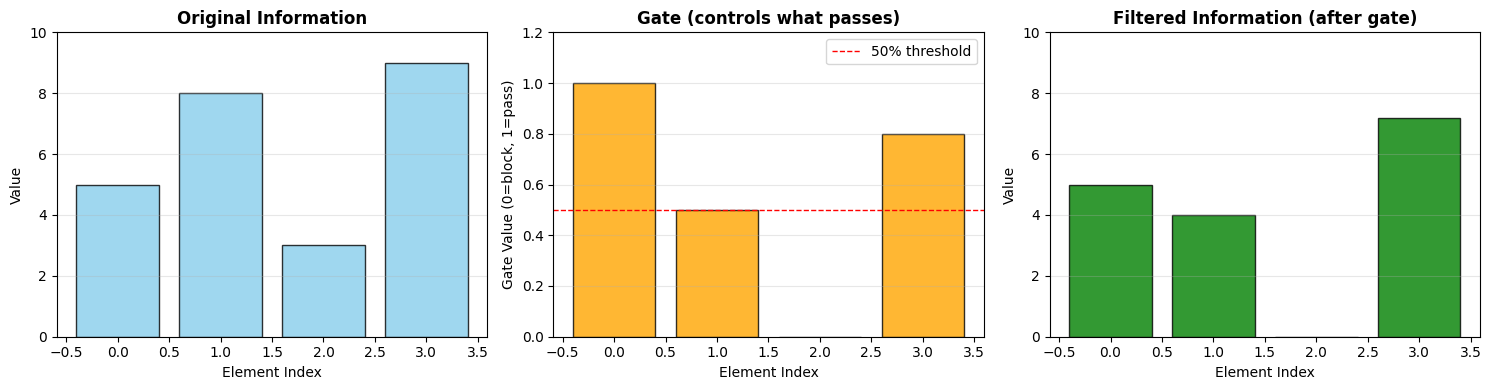


Key Insight: Element-wise multiplication lets gates control which
             information flows through the network!


In [19]:
# Example 2: Element-wise Multiplication (*)
# The * operator multiplies corresponding elements
# This is used for "gating" - selectively letting information through

print("\n" + "=" * 70)
print("EXAMPLE 2: Element-wise Multiplication (*) - GATING")
print("=" * 70)

# Imagine we have some information
information = torch.tensor([5.0, 8.0, 3.0, 9.0])
print(f"Information we have: {information}\n")

# A gate decides what information to keep (1.0) or discard (0.0)
# Values between 0 and 1 mean "partially keep"
gate = torch.tensor([1.0, 0.5, 0.0, 0.8])  # Keep all, keep half, discard, keep most
print(f"Gate values: {gate}")
print("  Gate[0]=1.0 means: keep 100% of information[0]")
print("  Gate[1]=0.5 means: keep 50% of information[1]")
print("  Gate[2]=0.0 means: keep 0% (discard) information[2]")
print("  Gate[3]=0.8 means: keep 80% of information[3]\n")

# Apply the gate using element-wise multiplication
filtered_information = gate * information
print(f"Filtered information: {filtered_information}")
print(f"  {gate[0]:.1f} * {information[0]:.1f} = {filtered_information[0]:.1f}")
print(f"  {gate[1]:.1f} * {information[1]:.1f} = {filtered_information[1]:.1f}")
print(f"  {gate[2]:.1f} * {information[2]:.1f} = {filtered_information[2]:.1f}")
print(f"  {gate[3]:.1f} * {information[3]:.1f} = {filtered_information[3]:.1f}")

# Visualize gating
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original information
axes[0].bar(range(4), information.numpy(), color='skyblue', edgecolor='black', alpha=0.8)
axes[0].set_title('Original Information', fontweight='bold')
axes[0].set_ylabel('Value')
axes[0].set_xlabel('Element Index')
axes[0].set_ylim(0, 10)
axes[0].grid(axis='y', alpha=0.3)

# Gate values
axes[1].bar(range(4), gate.numpy(), color='orange', edgecolor='black', alpha=0.8)
axes[1].set_title('Gate (controls what passes)', fontweight='bold')
axes[1].set_ylabel('Gate Value (0=block, 1=pass)')
axes[1].set_xlabel('Element Index')
axes[1].set_ylim(0, 1.2)
axes[1].axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='50% threshold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

# Filtered result
axes[2].bar(range(4), filtered_information.numpy(), color='green', edgecolor='black', alpha=0.8)
axes[2].set_title('Filtered Information (after gate)', fontweight='bold')
axes[2].set_ylabel('Value')
axes[2].set_xlabel('Element Index')
axes[2].set_ylim(0, 10)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight: Element-wise multiplication lets gates control which")
print("             information flows through the network!")


EXAMPLE 3: Sigmoid and Tanh Functions


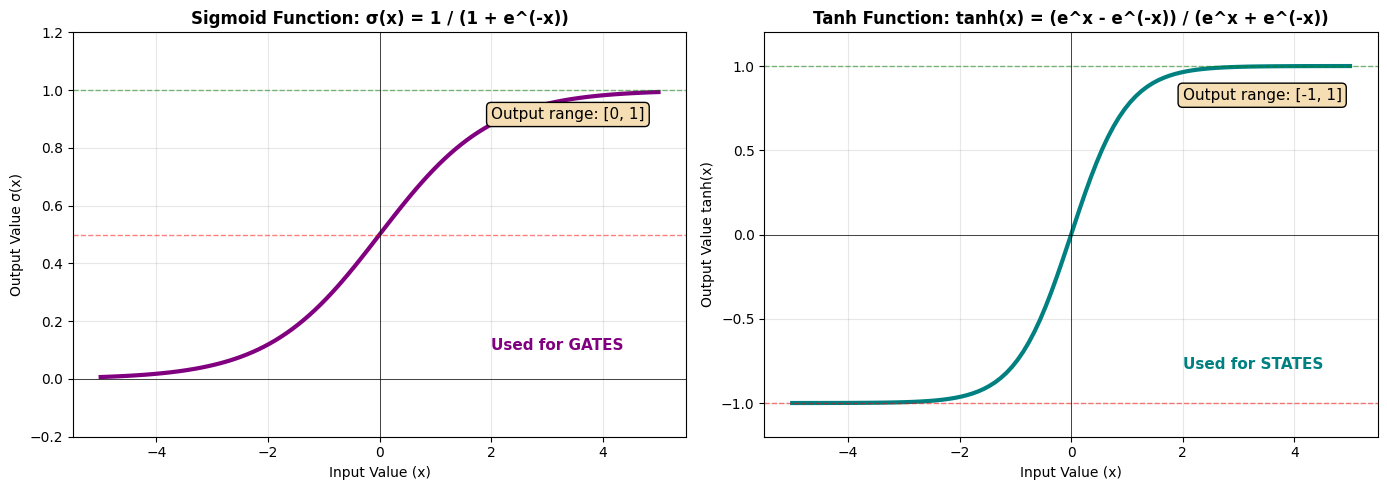


Sigmoid Examples (for gates):
  σ( -2.0) = 0.119  → Mostly CLOSED gate
  σ( -1.0) = 0.269  → Mostly CLOSED gate
  σ(  0.0) = 0.500  → Half-open gate
  σ(  1.0) = 0.731  → Mostly OPEN gate
  σ(  2.0) = 0.881  → Mostly OPEN gate
  σ(  5.0) = 0.993  → Mostly OPEN gate

Tanh Examples (for states):
  tanh( -2.0) = -0.964
  tanh( -1.0) = -0.762
  tanh(  0.0) =  0.000
  tanh(  1.0) =  0.762
  tanh(  2.0) =  0.964
  tanh(  5.0) =  1.000

Key Insights:
  • Sigmoid: Perfect for gates (0=closed, 1=open)
  • Tanh: Good for states (centered around 0, symmetric range)
  • Both functions are smooth (differentiable) - needed for backpropagation!


In [20]:
# Example 3: Sigmoid and Tanh Activation Functions
# These functions transform any input into a specific range

print("\n" + "=" * 70)
print("EXAMPLE 3: Sigmoid and Tanh Functions")
print("=" * 70)

# Create a range of input values
x = torch.linspace(-5, 5, 100)  # 100 values from -5 to 5

# Apply sigmoid: outputs between 0 and 1 (perfect for gates!)
sigmoid_output = torch.sigmoid(x)

# Apply tanh: outputs between -1 and 1 (good for cell state values)
tanh_output = torch.tanh(x)

# Visualize both functions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sigmoid
axes[0].plot(x.numpy(), sigmoid_output.numpy(), linewidth=3, color='purple')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axhline(y=1, color='green', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
axes[0].set_title('Sigmoid Function: σ(x) = 1 / (1 + e^(-x))', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Input Value (x)')
axes[0].set_ylabel('Output Value σ(x)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.2, 1.2)
axes[0].text(2, 0.9, 'Output range: [0, 1]', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat'))
axes[0].text(2, 0.1, 'Used for GATES', fontsize=11, fontweight='bold', color='purple')

# Tanh
axes[1].plot(x.numpy(), tanh_output.numpy(), linewidth=3, color='teal')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].axhline(y=1, color='green', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(y=-1, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
axes[1].set_title('Tanh Function: tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Input Value (x)')
axes[1].set_ylabel('Output Value tanh(x)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1.2, 1.2)
axes[1].text(2, 0.8, 'Output range: [-1, 1]', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat'))
axes[1].text(2, -0.8, 'Used for STATES', fontsize=11, fontweight='bold', color='teal')

plt.tight_layout()
plt.show()

# Show specific examples
print("\nSigmoid Examples (for gates):")
test_vals = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0, 5.0])
for val in test_vals:
    sig_val = torch.sigmoid(val)
    print(f"  σ({val:5.1f}) = {sig_val:.3f}", end="")
    if sig_val < 0.3:
        print("  → Mostly CLOSED gate")
    elif sig_val > 0.7:
        print("  → Mostly OPEN gate")
    else:
        print("  → Half-open gate")

print("\nTanh Examples (for states):")
for val in test_vals:
    tanh_val = torch.tanh(val)
    print(f"  tanh({val:5.1f}) = {tanh_val:6.3f}")

print("\nKey Insights:")
print("  • Sigmoid: Perfect for gates (0=closed, 1=open)")
print("  • Tanh: Good for states (centered around 0, symmetric range)")
print("  • Both functions are smooth (differentiable) - needed for backpropagation!")


EXAMPLE 4: Building a Simple LSTM Gate

Scenario: We want to decide whether to remember new information
Based on: current input + what we remembered before

Current input (x_t): tensor([0.8000, 0.3000, 0.5000])
Previous memory (h_t-1): tensor([0.2000, 0.9000, 0.1000])

Weight matrix W (for input):
tensor([[0.5000, 0.3000, 0.2000],
        [0.1000, 0.6000, 0.3000],
        [0.4000, 0.2000, 0.4000]])

Weight matrix U (for previous memory):
tensor([[0.3000, 0.4000, 0.3000],
        [0.5000, 0.2000, 0.3000],
        [0.2000, 0.5000, 0.3000]])

Bias (b): tensor([ 0.1000, -0.2000,  0.3000])

Step 1a - Input contribution (W @ x_t): tensor([0.5900, 0.4100, 0.5800])
Step 1b - Memory contribution (U @ h_t-1): tensor([0.4500, 0.3100, 0.5200])

Step 2 - Combined (W@x + U@h + b): tensor([1.1400, 0.5200, 1.4000])

Step 3 - Gate values σ(combined): tensor([0.7577, 0.6271, 0.8022])
  Gate[0] = 0.758 → 75.8% open
  Gate[1] = 0.627 → 62.7% open
  Gate[2] = 0.802 → 80.2% open

Step 4 - Apply gate to inf

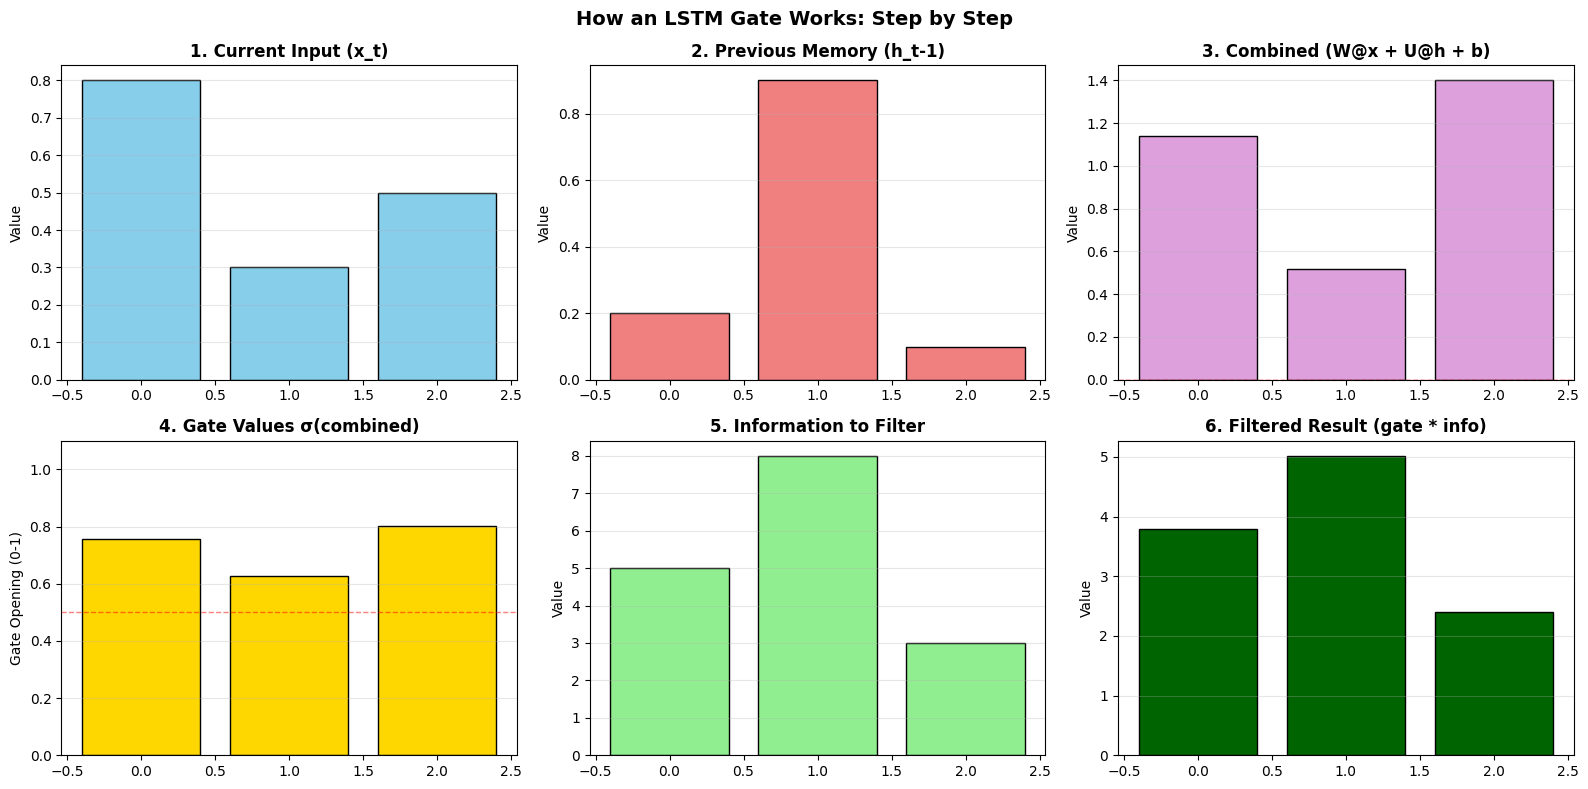


This is EXACTLY what happens in each LSTM gate!
The gate learns the weights W, U, and b to make good decisions.


In [21]:
# Example 4: How an LSTM Gate Works (Synthetic Example)
# Let's build a simple gate from scratch to understand the concept

print("\n" + "=" * 70)
print("EXAMPLE 4: Building a Simple LSTM Gate")
print("=" * 70)

# Simulate a simple scenario
print("\nScenario: We want to decide whether to remember new information")
print("Based on: current input + what we remembered before\n")

# Current input (e.g., word embedding)
current_input = torch.tensor([0.8, 0.3, 0.5])  # 3 features
print(f"Current input (x_t): {current_input}")

# What we remembered from before (previous hidden state)
previous_memory = torch.tensor([0.2, 0.9, 0.1])  # 3 features  
print(f"Previous memory (h_t-1): {previous_memory}\n")

# Weight matrices (normally learned, here we set them)
W = torch.tensor([
    [0.5, 0.3, 0.2],
    [0.1, 0.6, 0.3],
    [0.4, 0.2, 0.4]
])  # Weights for input
print(f"Weight matrix W (for input):\n{W}\n")

U = torch.tensor([
    [0.3, 0.4, 0.3],
    [0.5, 0.2, 0.3],
    [0.2, 0.5, 0.3]
])  # Weights for previous memory
print(f"Weight matrix U (for previous memory):\n{U}\n")

# Bias (shift the results)
b = torch.tensor([0.1, -0.2, 0.3])
print(f"Bias (b): {b}\n")

# STEP 1: Transform input and previous memory
input_contribution = W @ current_input  # Matrix multiplication
print(f"Step 1a - Input contribution (W @ x_t): {input_contribution}")

memory_contribution = U @ previous_memory  # Matrix multiplication
print(f"Step 1b - Memory contribution (U @ h_t-1): {memory_contribution}\n")

# STEP 2: Combine everything
combined = input_contribution + memory_contribution + b
print(f"Step 2 - Combined (W@x + U@h + b): {combined}\n")

# STEP 3: Apply sigmoid to get gate values (0 to 1)
gate_values = torch.sigmoid(combined)
print(f"Step 3 - Gate values σ(combined): {gate_values}")
print(f"  Gate[0] = {gate_values[0]:.3f} → {gate_values[0]*100:.1f}% open")
print(f"  Gate[1] = {gate_values[1]:.3f} → {gate_values[1]*100:.1f}% open")
print(f"  Gate[2] = {gate_values[2]:.3f} → {gate_values[2]*100:.1f}% open\n")

# STEP 4: Apply gate to some information
information_to_filter = torch.tensor([5.0, 8.0, 3.0])
filtered = gate_values * information_to_filter
print(f"Step 4 - Apply gate to information:")
print(f"  Original information: {information_to_filter}")
print(f"  After gate: {filtered}")

# Visualize the process
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('How an LSTM Gate Works: Step by Step', fontsize=14, fontweight='bold')

# Plot input
axes[0, 0].bar(range(3), current_input.numpy(), color='skyblue', edgecolor='black')
axes[0, 0].set_title('1. Current Input (x_t)', fontweight='bold')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot previous memory
axes[0, 1].bar(range(3), previous_memory.numpy(), color='lightcoral', edgecolor='black')
axes[0, 1].set_title('2. Previous Memory (h_t-1)', fontweight='bold')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot combined
axes[0, 2].bar(range(3), combined.numpy(), color='plum', edgecolor='black')
axes[0, 2].set_title('3. Combined (W@x + U@h + b)', fontweight='bold')
axes[0, 2].set_ylabel('Value')
axes[0, 2].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 2].grid(axis='y', alpha=0.3)

# Plot gate values
axes[1, 0].bar(range(3), gate_values.numpy(), color='gold', edgecolor='black')
axes[1, 0].set_title('4. Gate Values σ(combined)', fontweight='bold')
axes[1, 0].set_ylabel('Gate Opening (0-1)')
axes[1, 0].set_ylim(0, 1.1)
axes[1, 0].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot original information
axes[1, 1].bar(range(3), information_to_filter.numpy(), color='lightgreen', edgecolor='black')
axes[1, 1].set_title('5. Information to Filter', fontweight='bold')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(axis='y', alpha=0.3)

# Plot filtered result
axes[1, 2].bar(range(3), filtered.numpy(), color='darkgreen', edgecolor='black')
axes[1, 2].set_title('6. Filtered Result (gate * info)', fontweight='bold')
axes[1, 2].set_ylabel('Value')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("This is EXACTLY what happens in each LSTM gate!")
print("The gate learns the weights W, U, and b to make good decisions.")
print("="*70)

## Part 2: Data Preparation (Word-Level Tokenization)

In [22]:
# Load the tiny shakespeare dataset (use only first 20% for faster training)
with open('tiny.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Use only a subset for faster training
subset_size = len(raw_text) // 50 # Use 20% of the data
raw_text = raw_text[:subset_size]

print(f"Using subset: {len(raw_text):,} characters (20% of full dataset)")
print(f"First 200 characters:\n{raw_text[:200]}")

Using subset: 22,307 characters (20% of full dataset)
First 200 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [23]:
# Word-level tokenization
import re

# Simple word tokenizer that preserves punctuation
def tokenize(text):
    """Split text into words and punctuation tokens."""
    # Split on whitespace and punctuation, keeping punctuation as separate tokens
    tokens = re.findall(r"\w+|[^\w\s]", text.lower())
    return tokens

# Tokenize the text
tokens = tokenize(raw_text)

# Build vocabulary
vocab = sorted(set(tokens))
vocab_size = len(vocab)

# Create word-to-index and index-to-word mappings
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"\nVocabulary size: {vocab_size:,} unique words/tokens")
print(f"Total tokens: {len(tokens):,}")
print(f"\nFirst 20 vocab items: {vocab[:20]}")
print(f"Last 20 vocab items: {vocab[-20:]}")

# Encode text as indices
encoded = torch.tensor([word_to_idx[token] for token in tokens], dtype=torch.long)
print(f"\nEncoded tensor shape: {encoded.shape}")


Vocabulary size: 1,159 unique words/tokens
Total tokens: 5,229

First 20 vocab items: ['!', "'", ',', '-', '.', ':', ';', '?', 'a', 'abhorr', 'abhorring', 'about', 'absence', 'abundance', 'abundantly', 'account', 'accounted', 'accusations', 'accused', 'accusers']
Last 20 vocab items: ['world', 'worse', 'worshipful', 'worst', 'worthy', 'would', 'wrath', 'yarn', 'ye', 'years', 'yes', 'yet', 'yield', 'yonder', 'you', 'your', 'yours', 'yourself', 'yourselves', 'youth']

Encoded tensor shape: torch.Size([5229])


In [24]:
# Create training sequences (word-level) - using larger step for faster training
sequence_length = 20  # 20 words per sequence
examples = []

# Create overlapping sequences with larger step size for speed
for start in range(0, len(encoded) - sequence_length - 1, 10):  # Step by 10 words (was 5)
    chunk = encoded[start : start + sequence_length + 1]
    inputs = torch.nn.functional.one_hot(chunk[:-1], num_classes=vocab_size).float()
    targets = chunk[1:]
    examples.append((inputs, targets))

print(f"Number of training sequences: {len(examples):,}")
print(f"Input shape per sequence: {examples[0][0].shape}")
print(f"Target shape per sequence: {examples[0][1].shape}")

# Show a sample sequence
sample_seq = examples[0][1][:10]
sample_words = [idx_to_word[idx.item()] for idx in sample_seq]
print(f"\nSample target sequence (first 10 words): {' '.join(sample_words)}")

Number of training sequences: 521
Input shape per sequence: torch.Size([20, 1159])
Target shape per sequence: torch.Size([20])

Sample target sequence (first 10 words): citizen : before we proceed any further , hear me


## Part 3: LSTM Implementation from Scratch

In [25]:
class LSTMCell(nn.Module):
    """
    Single LSTM cell - the core component that processes one timestep.
    This implements the equations we saw earlier with detailed comments.
    """
    
    def __init__(self, input_size: int, hidden_size: int):
        """
        Initialize the LSTM cell with learnable parameters.
        
        Args:
            input_size: Size of input vector (e.g., size of word embedding)
            hidden_size: Size of hidden state (controls memory capacity)
        """
        super().__init__()  # Initialize the parent nn.Module class
        self.input_size = input_size      # Store input size
        self.hidden_size = hidden_size    # Store hidden size
        
        # ========================================================================
        # FORGET GATE PARAMETERS - Controls what to forget from previous memory
        # ========================================================================
        # W_f: Weight matrix that transforms current input
        # Shape: (hidden_size, input_size)
        # Example: if hidden_size=64 and input_size=3000, shape is (64, 3000)
        self.W_f = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        
        # U_f: Weight matrix that transforms previous hidden state
        # Shape: (hidden_size, hidden_size)
        # Example: if hidden_size=64, shape is (64, 64)
        self.U_f = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        
        # b_f: Bias term for forget gate
        # Shape: (hidden_size,)
        # Initialized to 1.0 so the network "forgets less" initially
        # This prevents accidentally forgetting everything at the start
        self.b_f = nn.Parameter(torch.ones(hidden_size))
        
        # ========================================================================
        # INPUT GATE PARAMETERS - Controls what new information to add
        # ========================================================================
        # W_i: Weight matrix for current input
        self.W_i = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        
        # U_i: Weight matrix for previous hidden state
        self.U_i = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        
        # b_i: Bias term for input gate
        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        
        # ========================================================================
        # CANDIDATE STATE PARAMETERS - Creates new candidate information
        # ========================================================================
        # W_g: Weight matrix for current input
        self.W_g = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        
        # U_g: Weight matrix for previous hidden state
        self.U_g = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        
        # b_g: Bias term for candidate state
        self.b_g = nn.Parameter(torch.zeros(hidden_size))
        
        # ========================================================================
        # OUTPUT GATE PARAMETERS - Controls what to output from the cell
        # ========================================================================
        # W_o: Weight matrix for current input
        self.W_o = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        
        # U_o: Weight matrix for previous hidden state
        self.U_o = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        
        # b_o: Bias term for output gate
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
    
    def forward(self, x_t, h_prev, C_prev, return_gates=False):
        """
        Process one timestep through the LSTM cell.
        
        Args:
            x_t: Current input vector at time t, shape: (input_size,)
            h_prev: Previous hidden state from time t-1, shape: (hidden_size,)
            C_prev: Previous cell state from time t-1, shape: (hidden_size,)
            return_gates: If True, also return gate values for visualization
            
        Returns:
            h_t: New hidden state at time t, shape: (hidden_size,)
            C_t: New cell state at time t, shape: (hidden_size,)
            gates (optional): Dictionary with all gate values
        """
        
        # ========================================================================
        # STEP 1: FORGET GATE - Decide what to forget from previous memory
        # ========================================================================
        # Formula: f_t = σ(W_f @ x_t + U_f @ h_prev + b_f)
        # 
        # Step by step:
        # 1. W_f @ x_t: Transform current input (matrix mult)
        # 2. U_f @ h_prev: Transform previous hidden state (matrix mult)
        # 3. Add both transformations plus bias
        # 4. Apply sigmoid to get values between 0 and 1
        #    - f_t[i] ≈ 0 means "forget this memory element"
        #    - f_t[i] ≈ 1 means "keep this memory element"
        f_t = torch.sigmoid(self.W_f @ x_t + self.U_f @ h_prev + self.b_f)
        
        # ========================================================================
        # STEP 2: INPUT GATE - Decide what new information to add
        # ========================================================================
        # Formula: i_t = σ(W_i @ x_t + U_i @ h_prev + b_i)
        #
        # Similar to forget gate but controls what NEW info to store
        # i_t[i] ≈ 0 means "don't add new info here"
        # i_t[i] ≈ 1 means "add new info here"
        i_t = torch.sigmoid(self.W_i @ x_t + self.U_i @ h_prev + self.b_i)
        
        # ========================================================================
        # STEP 3: CANDIDATE STATE - Create new information to potentially add
        # ========================================================================
        # Formula: g_t = tanh(W_g @ x_t + U_g @ h_prev + b_g)
        #
        # This creates NEW candidate values to add to memory
        # Uses tanh (range -1 to 1) instead of sigmoid
        # These are the actual new values (not gates)
        g_t = torch.tanh(self.W_g @ x_t + self.U_g @ h_prev + self.b_g)
        
        # ========================================================================
        # STEP 4: OUTPUT GATE - Decide what to output from current state
        # ========================================================================
        # Formula: o_t = σ(W_o @ x_t + U_o @ h_prev + self.b_o)
        #
        # Controls how much of the cell state to expose as output
        # o_t[i] ≈ 0 means "don't output this part of memory"
        # o_t[i] ≈ 1 means "output this part of memory"
        o_t = torch.sigmoid(self.W_o @ x_t + self.U_o @ h_prev + self.b_o)
        
        # ========================================================================
        # STEP 5: UPDATE CELL STATE - The long-term memory
        # ========================================================================
        # Formula: C_t = f_t * C_prev + i_t * g_t
        #
        # This is the KEY to LSTM's power! Two parts:
        # 1. f_t * C_prev: Keep some of old memory (element-wise mult)
        # 2. i_t * g_t: Add some of new candidate values (element-wise mult)
        #
        # The * is element-wise multiplication (gating)
        # If f_t[i]=1 and i_t[i]=0: just keep old value C_prev[i]
        # If f_t[i]=0 and i_t[i]=1: replace with new value g_t[i]
        # If f_t[i]=0.5 and i_t[i]=0.5: blend old and new
        C_t = f_t * C_prev + i_t * g_t
        
        # ========================================================================
        # STEP 6: UPDATE HIDDEN STATE - The short-term memory/output
        # ========================================================================
        # Formula: h_t = o_t * tanh(C_t)
        #
        # 1. tanh(C_t): Squash cell state to range [-1, 1]
        # 2. o_t * tanh(C_t): Output gate controls what gets exposed
        #
        # This is what gets passed to the next timestep and used for predictions
        h_t = o_t * torch.tanh(C_t)
        
        # ========================================================================
        # OPTIONAL: Return gate values for visualization
        # ========================================================================
        if return_gates:
            # Return hidden state, cell state, and all gate activations
            return h_t, C_t, {
                'forget': f_t,      # What we're forgetting (0-1)
                'input': i_t,       # What we're adding (0-1)
                'candidate': g_t,   # New candidate values (-1 to 1)
                'output': o_t,      # What we're outputting (0-1)
                'cell': C_t         # Current long-term memory
            }
        
        # Return just the hidden state and cell state
        return h_t, C_t

In [26]:
class CustomLSTM(nn.Module):
    """LSTM network for character-level language modeling."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)
        
        # Output projection
        self.W_y = nn.Parameter(torch.randn(output_size, hidden_size) * 0.1)
        self.b_y = nn.Parameter(torch.zeros(output_size))
    
    def forward(self, inputs, h0=None, C0=None, return_gates=False):
        """
        inputs: (seq_len, input_size)
        h0: initial hidden state (hidden_size,)
        C0: initial cell state (hidden_size,)
        """
        if h0 is None:
            h_t = inputs.new_zeros(self.hidden_size)
        else:
            h_t = h0
            
        if C0 is None:
            C_t = inputs.new_zeros(self.hidden_size)
        else:
            C_t = C0
        
        outputs = []
        gates_history = [] if return_gates else None
        
        for x_t in inputs:
            if return_gates:
                h_t, C_t, gates = self.lstm_cell(x_t, h_t, C_t, return_gates=True)
                gates_history.append(gates)
            else:
                h_t, C_t = self.lstm_cell(x_t, h_t, C_t)
            
            # Project hidden state to output
            y_t = self.W_y @ h_t + self.b_y
            outputs.append(y_t)
        
        if return_gates:
            return torch.stack(outputs), h_t, C_t, gates_history
        
        return torch.stack(outputs), h_t, C_t


# Initialize model
hidden_size = 64
model = CustomLSTM(vocab_size, hidden_size, vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Hidden size: {hidden_size}")
print(f"Vocab size: {vocab_size}")

Model initialized with 388679 parameters
Hidden size: 64
Vocab size: 1159


## Part 4: Visualize LSTM Gates Before Training

Let's see how the gates behave before any training.

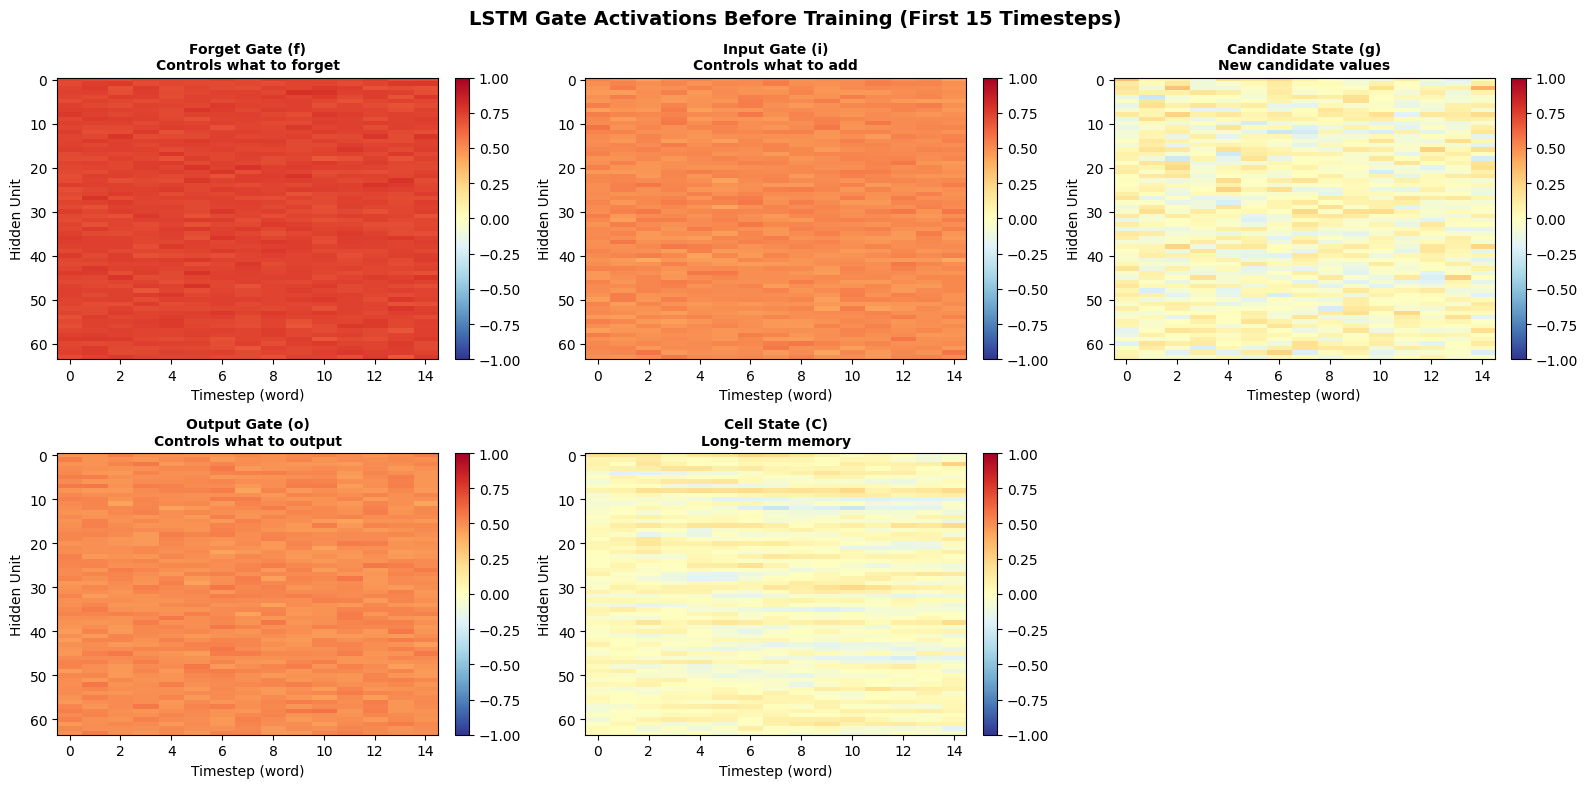


Gate Statistics (Before Training):
Forget Gate (f)      - Mean: 0.732, Std: 0.021
Input Gate (i)       - Mean: 0.500, Std: 0.026
Candidate State (g)  - Mean: 0.001, Std: 0.104
Output Gate (o)      - Mean: 0.499, Std: 0.026
Cell State (C)       - Mean: 0.002, Std: 0.082


In [27]:
# Test forward pass with gate visualization
model.eval()
with torch.no_grad():
    test_input = examples[0][0][:15]  # First 15 words
    outputs, h_final, C_final, gates_history = model(test_input, return_gates=True)

# Visualize gate activations over time
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('LSTM Gate Activations Before Training (First 15 Timesteps)', 
             fontsize=14, fontweight='bold')

gate_names = ['forget', 'input', 'candidate', 'output', 'cell']
gate_titles = ['Forget Gate (f)', 'Input Gate (i)', 'Candidate State (g)', 
               'Output Gate (o)', 'Cell State (C)']
gate_descriptions = [
    'Controls what to forget',
    'Controls what to add',
    'New candidate values',
    'Controls what to output',
    'Long-term memory'
]

for idx, (gate_name, title, desc) in enumerate(zip(gate_names, gate_titles, gate_descriptions)):
    if idx >= 5:
        break
    
    ax = axes[idx // 3, idx % 3]
    
    # Extract gate values over time
    gate_values = torch.stack([g[gate_name] for g in gates_history]).numpy()
    
    # Plot heatmap
    im = ax.imshow(gate_values.T, aspect='auto', cmap='RdYlBu_r', vmin=-1, vmax=1)
    ax.set_title(f'{title}\n{desc}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Timestep (word)')
    ax.set_ylabel('Hidden Unit')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nGate Statistics (Before Training):")
print("=" * 60)
for gate_name, title in zip(gate_names, gate_titles):
    gate_values = torch.stack([g[gate_name] for g in gates_history])
    print(f"{title:20s} - Mean: {gate_values.mean():.3f}, Std: {gate_values.std():.3f}")

## Part 5: Training the LSTM

In [28]:
# Training loop with progress tracking
model.train()
epochs = 30  # Reduced from 50 for faster training with subset
loss_history = []

print("Training LSTM on word-level tokens (subset)...\n")
for epoch in range(1, epochs + 1):
    total_loss = 0.0
    
    for inputs, targets in examples:
        logits, _, _ = model(inputs)
        loss = criterion(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(examples)
    loss_history.append(avg_loss)
    
    if epoch % 5 == 0 or epoch == 1:
        perplexity = np.exp(avg_loss)
        print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Perplexity: {perplexity:.2f}")

print("\nTraining complete!")

Training LSTM on word-level tokens (subset)...

Epoch   1 | Loss: 5.7839 | Perplexity: 325.03
Epoch   5 | Loss: 2.7514 | Perplexity: 15.67
Epoch  10 | Loss: 1.1030 | Perplexity: 3.01
Epoch  15 | Loss: 0.4294 | Perplexity: 1.54
Epoch  20 | Loss: 0.2739 | Perplexity: 1.32
Epoch  25 | Loss: 0.1834 | Perplexity: 1.20
Epoch  30 | Loss: 0.3689 | Perplexity: 1.45

Training complete!


## Part 6: Visualize Training Progress

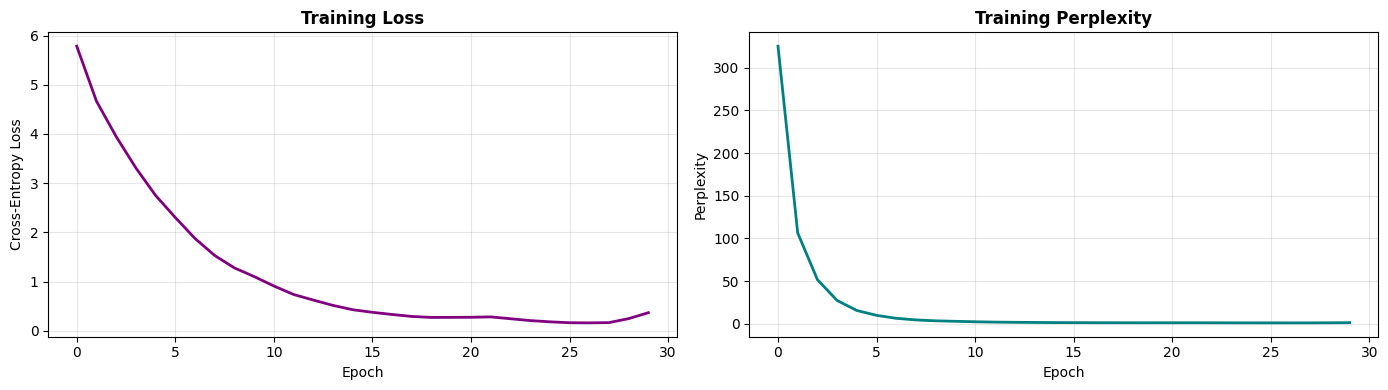


Training Summary:
Initial Loss: 5.7839 → Final Loss: 0.3689
Initial Perplexity: 325.03 → Final Perplexity: 1.45
Improvement: 93.6% loss reduction


In [29]:
# Plot training curves
perplexity_history = [np.exp(loss) for loss in loss_history]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Loss curve
ax1.plot(loss_history, color='purple', linewidth=2)
ax1.set_title('Training Loss', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.grid(True, alpha=0.3)

# Perplexity curve
ax2.plot(perplexity_history, color='teal', linewidth=2)
ax2.set_title('Training Perplexity', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining Summary:")
print("=" * 60)
print(f"Initial Loss: {loss_history[0]:.4f} → Final Loss: {loss_history[-1]:.4f}")
print(f"Initial Perplexity: {perplexity_history[0]:.2f} → Final Perplexity: {perplexity_history[-1]:.2f}")
print(f"Improvement: {100 * (1 - loss_history[-1]/loss_history[0]):.1f}% loss reduction")

## Part 7: Visualize LSTM Gates After Training

Let's see how the trained gates behave differently.

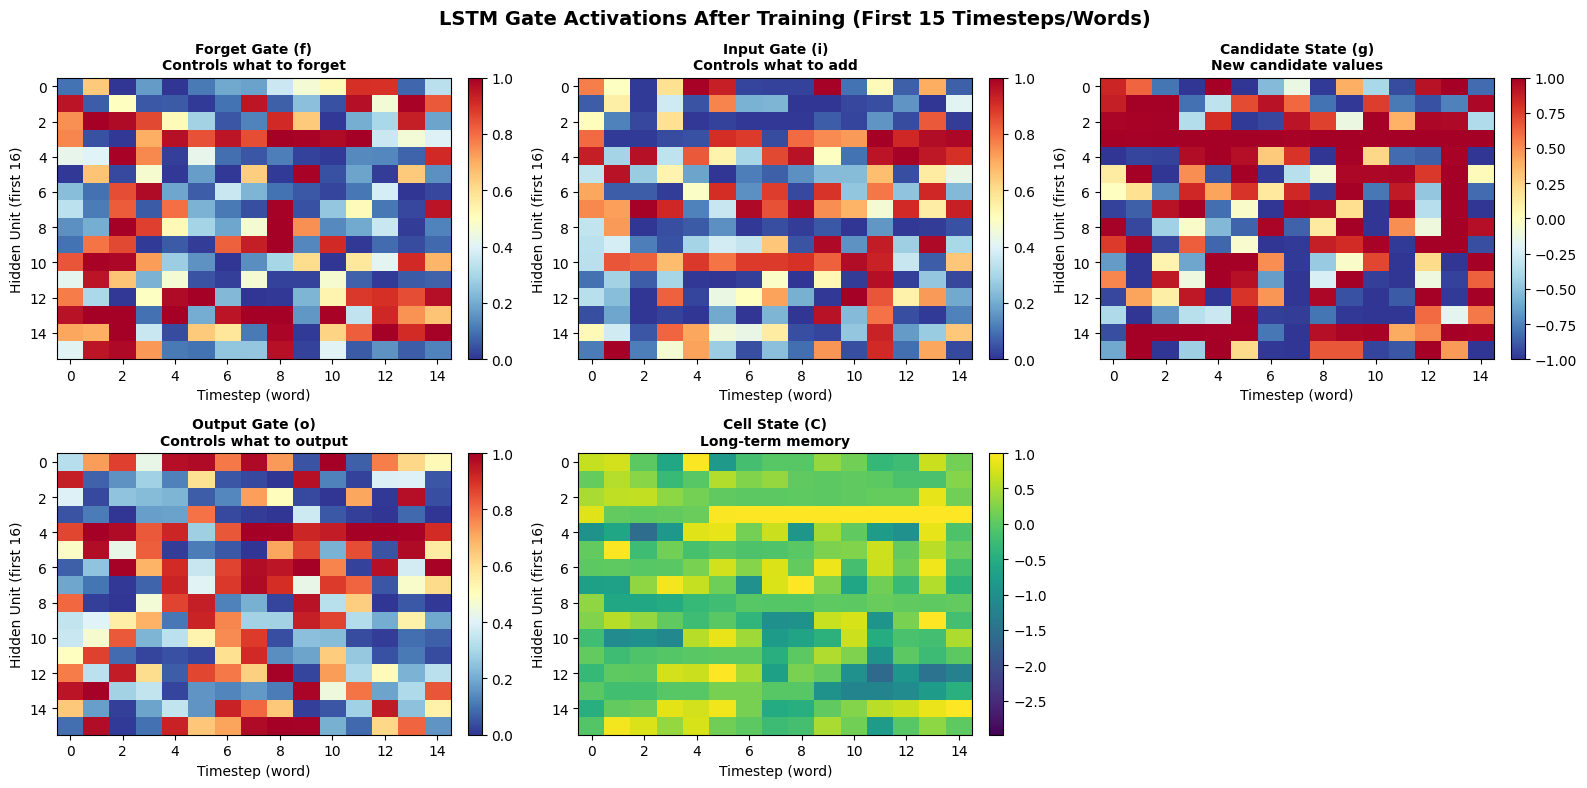


Gate Statistics (After Training):
Forget Gate (f)      - Mean: 0.469, Std: 0.378
Input Gate (i)       - Mean: 0.383, Std: 0.351
Candidate State (g)  - Mean: 0.005, Std: 0.838
Output Gate (o)      - Mean: 0.438, Std: 0.349
Cell State (C)       - Mean: 0.024, Std: 0.708


In [30]:
# Test forward pass after training
model.eval()
with torch.no_grad():
    test_input = examples[0][0][:15]  # First 15 words
    outputs, h_final, C_final, gates_history = model(test_input, return_gates=True)

# Visualize gate activations
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('LSTM Gate Activations After Training (First 15 Timesteps/Words)', 
             fontsize=14, fontweight='bold')

for idx, (gate_name, title, desc) in enumerate(zip(gate_names, gate_titles, gate_descriptions)):
    if idx >= 5:
        break
    
    ax = axes[idx // 3, idx % 3]
    
    gate_values = torch.stack([g[gate_name] for g in gates_history]).numpy()
    
    # Use different colormap for cell state
    cmap = 'RdYlBu_r' if gate_name != 'cell' else 'viridis'
    vmin = -1 if gate_name == 'candidate' else (gate_values.min() if gate_name == 'cell' else 0)
    vmax = 1
    
    im = ax.imshow(gate_values.T[:16], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f'{title}\n{desc}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Timestep (word)')
    ax.set_ylabel('Hidden Unit (first 16)')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nGate Statistics (After Training):")
print("=" * 60)
for gate_name, title in zip(gate_names, gate_titles):
    gate_values = torch.stack([g[gate_name] for g in gates_history])
    print(f"{title:20s} - Mean: {gate_values.mean():.3f}, Std: {gate_values.std():.3f}")

## Part 8: Analyze Gate Behavior on Sample Text

Let's trace how gates respond to specific input characters.

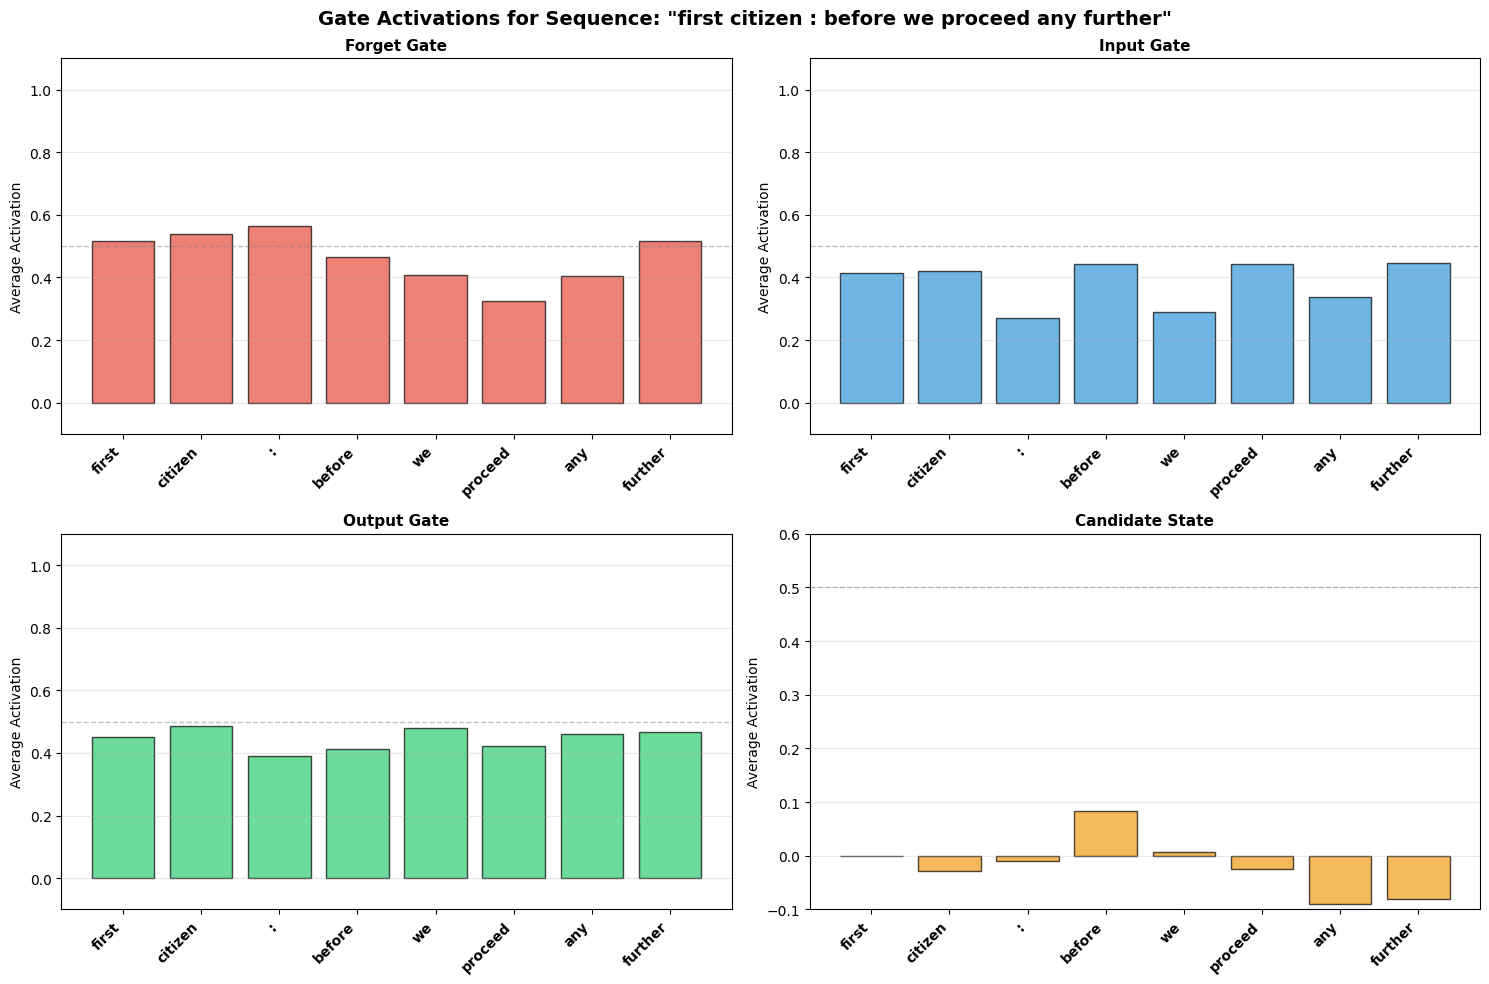

In [31]:
# Analyze gate behavior on a meaningful sequence
test_sequence_words = ["first", "citizen", ":", "before", "we", "proceed", "any", "further"]
test_encoded = torch.tensor([word_to_idx.get(w, 0) for w in test_sequence_words], dtype=torch.long)
test_onehot = F.one_hot(test_encoded, num_classes=vocab_size).float()

model.eval()
with torch.no_grad():
    outputs, h_final, C_final, gates_history = model(test_onehot, return_gates=True)

# Plot average gate activations per word
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Gate Activations for Sequence: "{" ".join(test_sequence_words)}"', 
             fontsize=14, fontweight='bold')

gate_subset = ['forget', 'input', 'output', 'candidate']
gate_titles_subset = ['Forget Gate', 'Input Gate', 'Output Gate', 'Candidate State']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for idx, (gate_name, title, color) in enumerate(zip(gate_subset, gate_titles_subset, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Average across hidden units
    gate_values = torch.stack([g[gate_name].mean() for g in gates_history]).numpy()
    
    ax.bar(range(len(test_sequence_words)), gate_values, color=color, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(test_sequence_words)))
    ax.set_xticklabels(test_sequence_words, fontsize=10, fontweight='bold', rotation=45, ha='right')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('Average Activation')
    ax.set_ylim(-0.1, 1.1 if gate_name != 'candidate' else 0.6)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

## Part 9: Text Generation with LSTM

In [32]:
def sample_lstm(model: CustomLSTM, seed_words: list, length: int = 50, temperature: float = 1.0) -> str:
    """Generate text using the trained LSTM.
    
    Args:
        model: Trained LSTM model
        seed_words: Starting words as a list
        length: Number of words to generate
        temperature: Sampling temperature (higher = more random)
    """
    model.eval()
    with torch.no_grad():
        h_t = None
        C_t = None
        generated = list(seed_words)
        
        # Process seed words (all but last)
        for word in seed_words[:-1]:
            if word in word_to_idx:
                vec = F.one_hot(torch.tensor(word_to_idx[word]), num_classes=vocab_size).float()
                _, h_t, C_t = model(vec.unsqueeze(0), h_t, C_t)
        
        # Generate new words
        current_word = seed_words[-1] if seed_words[-1] in word_to_idx else vocab[0]
        for _ in range(length):
            vec = F.one_hot(torch.tensor(word_to_idx[current_word]), num_classes=vocab_size).float()
            logits, h_t, C_t = model(vec.unsqueeze(0), h_t, C_t)
            
            # Apply temperature
            logits = logits[-1] / temperature
            probs = F.softmax(logits, dim=0)
            
            word_idx = torch.multinomial(probs, num_samples=1).item()
            current_word = idx_to_word[word_idx]
            generated.append(current_word)
    
    model.train()
    # Join words with spaces, handling punctuation
    result = []
    for i, word in enumerate(generated):
        if word in '.,!?;:\'"' and result:
            result[-1] += word
        else:
            result.append(word)
    return ' '.join(result)


# Generate samples with different temperatures
seed_words = ["first", "citizen", ":"]

print("Generated Text Samples:\n")
print("=" * 80)

for temp in [0.5, 0.8, 1.0, 1.2]:
    print(f"\n[Temperature = {temp}]")
    print("-" * 80)
    generated = sample_lstm(model, seed_words, length=40, temperature=temp)
    print(generated)
    print()

Generated Text Samples:


[Temperature = 0.5]
--------------------------------------------------------------------------------
first citizen: should by the cormorant belly be restrain' d, farewell. marcius: noble marcius! first senator:' tis not to save labour, nor that i want love. valeria: you shall go with us


[Temperature = 0.8]
--------------------------------------------------------------------------------
first citizen: very well; and could be content to give him good report fort, but that the bran.' what say you to' t. i sin in envying his nobility, and call him noble that was


[Temperature = 1.0]
--------------------------------------------------------------------------------
first citizen: it was this good belly, i sprang not more in joy at first hearing he did, and were i want love. valeria: you shall go with us to the dearth, on the gods, keep


[Temperature = 1.2]
--------------------------------------------------------------------------------
first citizen: it was your 

## Part 10: LSTM vs Vanilla RNN Comparison

In [33]:
# Train a vanilla RNN for comparison
class VanillaRNN(nn.Module):
    """Simple RNN for comparison."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Parameter(torch.randn(hidden_size, input_size) * 0.05)
        self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.05)
        self.bh = nn.Parameter(torch.zeros(hidden_size))
        self.Why = nn.Parameter(torch.randn(output_size, hidden_size) * 0.05)
        self.by = nn.Parameter(torch.zeros(output_size))
    
    def forward(self, inputs, h0=None):
        if h0 is None:
            h_t = inputs.new_zeros(self.hidden_size)
        else:
            h_t = h0
        
        outputs = []
        for x_t in inputs:
            h_t = torch.tanh(self.Wxh @ x_t + self.Whh @ h_t + self.bh)
            y_t = self.Why @ h_t + self.by
            outputs.append(y_t)
        
        return torch.stack(outputs), h_t


# Train both models
print("Training vanilla RNN for comparison...\n")

rnn_model = VanillaRNN(vocab_size, hidden_size, vocab_size)
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01)
rnn_loss_history = []

for epoch in range(1, epochs + 1):
    total_loss = 0.0
    for inputs, targets in examples:
        logits, _ = rnn_model(inputs)
        loss = criterion(logits, targets)
        rnn_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), max_norm=5.0)
        rnn_optimizer.step()
        total_loss += loss.item()
    
    rnn_loss_history.append(total_loss / len(examples))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | RNN Loss: {rnn_loss_history[-1]:.4f}")

print("\nComparison training complete!")

Training vanilla RNN for comparison...

Epoch  10 | RNN Loss: 5.4744
Epoch  20 | RNN Loss: 4.8797
Epoch  30 | RNN Loss: 5.7731

Comparison training complete!


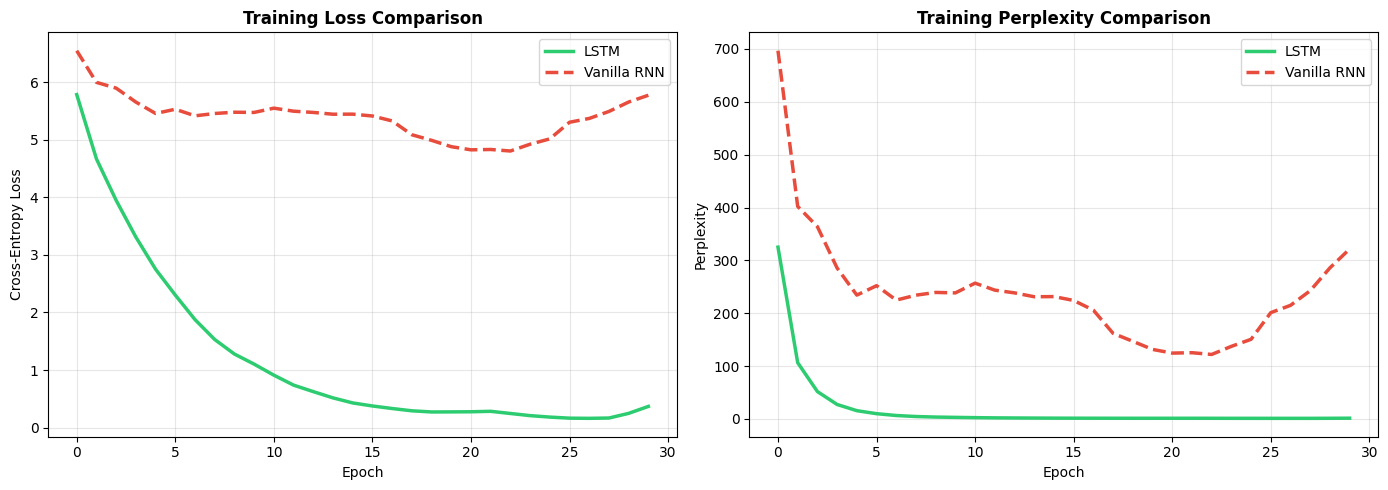


Final Results Comparison:
LSTM     - Final Loss: 0.3689, Perplexity: 1.45
Vanilla RNN - Final Loss: 5.7731, Perplexity: 321.54

LSTM Improvement: 93.6% better


In [34]:
# Compare LSTM vs RNN performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
ax1 = axes[0]
ax1.plot(loss_history, label='LSTM', color='#2ecc71', linewidth=2.5)
ax1.plot(rnn_loss_history, label='Vanilla RNN', color='#e74c3c', linewidth=2.5, linestyle='--')
ax1.set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Perplexity comparison
ax2 = axes[1]
lstm_perplexity = [np.exp(loss) for loss in loss_history]
rnn_perplexity = [np.exp(loss) for loss in rnn_loss_history]
ax2.plot(lstm_perplexity, label='LSTM', color='#2ecc71', linewidth=2.5)
ax2.plot(rnn_perplexity, label='Vanilla RNN', color='#e74c3c', linewidth=2.5, linestyle='--')
ax2.set_title('Training Perplexity Comparison', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Results Comparison:")
print("=" * 60)
print(f"LSTM     - Final Loss: {loss_history[-1]:.4f}, Perplexity: {lstm_perplexity[-1]:.2f}")
print(f"Vanilla RNN - Final Loss: {rnn_loss_history[-1]:.4f}, Perplexity: {rnn_perplexity[-1]:.2f}")
print(f"\nLSTM Improvement: {100 * (rnn_loss_history[-1] - loss_history[-1]) / rnn_loss_history[-1]:.1f}% better")

## Part 11: Gradient Flow Analysis

Let's analyze why LSTM handles gradients better than vanilla RNN.

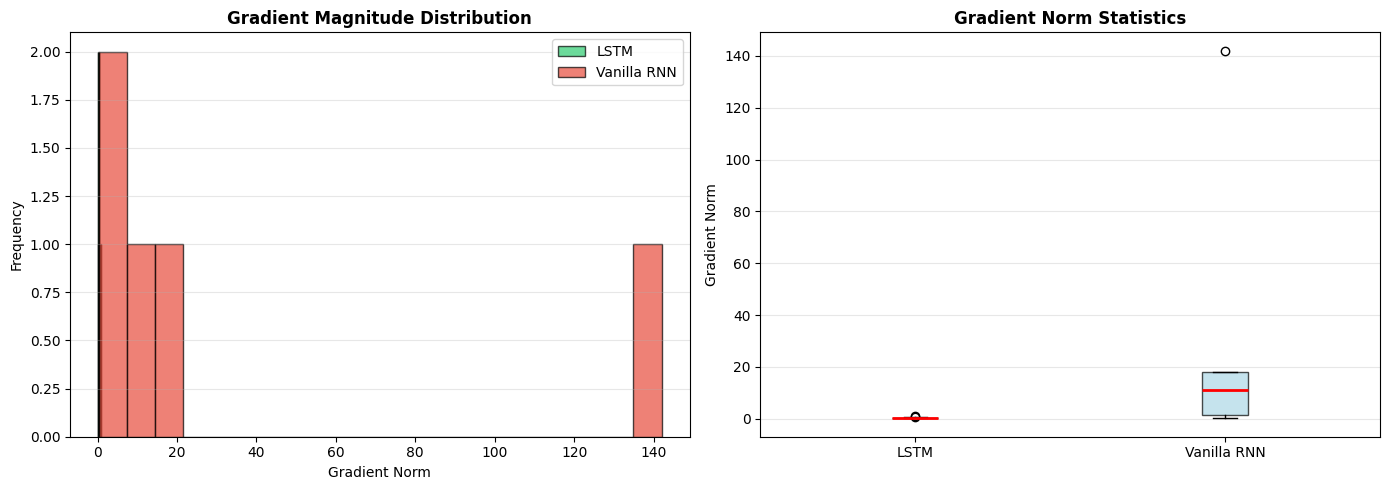


Gradient Statistics:
LSTM     - Mean: 0.4073, Std: 0.2112, Max: 0.9292
Vanilla RNN - Mean: 34.5560, Std: 54.1016, Max: 141.9869


In [35]:
# Analyze gradient flow through time
def analyze_gradients(model, model_type='LSTM'):
    """Compute gradients for a sequence and analyze their magnitude."""
    model.train()
    inputs, targets = examples[0]
    
    # Forward pass
    if model_type == 'LSTM':
        logits, _, _ = model(inputs)
    else:
        logits, _ = model(inputs)
    
    loss = criterion(logits, targets)
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Collect gradient norms
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())
    
    return grad_norms


# Analyze both models
lstm_grads = analyze_gradients(model, 'LSTM')
rnn_grads = analyze_gradients(rnn_model, 'RNN')

# Visualize gradient magnitudes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(lstm_grads, bins=20, alpha=0.7, label='LSTM', color='#2ecc71', edgecolor='black')
ax1.hist(rnn_grads, bins=20, alpha=0.7, label='Vanilla RNN', color='#e74c3c', edgecolor='black')
ax1.set_xlabel('Gradient Norm')
ax1.set_ylabel('Frequency')
ax1.set_title('Gradient Magnitude Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Box plot
box_data = [lstm_grads, rnn_grads]
bp = ax2.boxplot(box_data, labels=['LSTM', 'Vanilla RNN'], patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Gradient Norm')
ax2.set_title('Gradient Norm Statistics', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nGradient Statistics:")
print("=" * 60)
print(f"LSTM     - Mean: {np.mean(lstm_grads):.4f}, Std: {np.std(lstm_grads):.4f}, Max: {np.max(lstm_grads):.4f}")
print(f"Vanilla RNN - Mean: {np.mean(rnn_grads):.4f}, Std: {np.std(rnn_grads):.4f}, Max: {np.max(rnn_grads):.4f}")

## Part 12: Key Insights and Conclusions

### Why LSTM Works Better:

1. **Cell State Highway**: The cell state provides a direct path for gradients to flow backward through time with minimal modification.

2. **Multiplicative Gates**: Gates use element-wise multiplication rather than matrix multiplication, allowing selective information flow.

3. **Forget Gate Bias**: Initialized to 1, the forget gate starts by remembering everything, preventing early information loss.

4. **Gradient Control**: Gates can protect against both vanishing (by keeping forget gate high) and exploding (by closing gates) gradients.

### Observed Improvements:

- **Lower Final Loss**: LSTM achieves better loss convergence
- **Stable Training**: More consistent gradient magnitudes
- **Better Text Quality**: Generated text maintains longer-term coherence
- **Faster Convergence**: Reaches good performance in fewer epochs

In [36]:
# Final comparison: Generate text from both models
def sample_rnn(model: VanillaRNN, seed_words: list, length: int = 40) -> str:
    """Generate text using vanilla RNN."""
    model.eval()
    with torch.no_grad():
        h_t = None
        generated = list(seed_words)
        
        for word in seed_words[:-1]:
            if word in word_to_idx:
                vec = F.one_hot(torch.tensor(word_to_idx[word]), num_classes=vocab_size).float()
                _, h_t = model(vec.unsqueeze(0), h_t)
        
        current_word = seed_words[-1] if seed_words[-1] in word_to_idx else vocab[0]
        for _ in range(length):
            vec = F.one_hot(torch.tensor(word_to_idx[current_word]), num_classes=vocab_size).float()
            logits, h_t = model(vec.unsqueeze(0), h_t)
            probs = F.softmax(logits[-1], dim=0)
            word_idx = torch.multinomial(probs, num_samples=1).item()
            current_word = idx_to_word[word_idx]
            generated.append(current_word)
    
    # Join words with spaces, handling punctuation
    result = []
    for word in generated:
        if word in '.,!?;:\'"' and result:
            result[-1] += word
        else:
            result.append(word)
    return ' '.join(result)


print("\n" + "=" * 80)
print("FINAL TEXT GENERATION COMPARISON")
print("=" * 80)

seed_words = ["first", "citizen", ":"]

print(f"\nSeed: \"{' '.join(seed_words)}\"\n")

print("\n[LSTM OUTPUT]")
print("-" * 80)
lstm_text = sample_lstm(model, seed_words, length=40, temperature=0.8)
print(lstm_text)

print("\n[VANILLA RNN OUTPUT]")
print("-" * 80)
rnn_text = sample_rnn(rnn_model, seed_words, length=40)
print(rnn_text)
print("\n" + "=" * 80)


FINAL TEXT GENERATION COMPARISON

Seed: "first citizen :"


[LSTM OUTPUT]
--------------------------------------------------------------------------------
first citizen: very well; and could be content to give him good report fort, but speak not how honour than in the embracements of his bed; i pray you; cominius. marcius: all the contagion of the

[VANILLA RNN OUTPUT]
--------------------------------------------------------------------------------
first citizen: such, and hence? hark. volumnia, at faces army! there, go are shall both widens famish,; and were the word that red: sir. pale, and walls, disease earned,

